# Understanding K-means Clustering

a technique used to organize data into groups based on their similarity.

a popular unsupervised machine learning algorithm used to partition a dataset into K distinct clusters.

**Key Concepts:**

* K: The number of clusters to be formed (you must specify this in advance).
* Centroids: The center of each cluster. Each centroid is a point in the feature space that represents the average of all points in the cluster.
* Centroid = ((X1 + X2 + … + Xn) / n, (Y1 + Y2 + … + Yn) / n)



***Distance measure***

* To achieve this, clustering algorithms utilize a critical component known as a ***distance measure*** to quantify the similarity or dissimilarity between data points.
* Euclidean Distance = √((X1 — X2)² + (Y1 — Y2)²)

In [ ]:
import numpy as np
def EuclideanDistance(p1,p2):
    return np.sqrt(np.sum((p1-p2)**2))

# from scipy.spatial.distance import euclidean
# distance_p1_p2 = euclidean(p1,p2)

***Objective:***

* Grouping similar data points:
* Minimizing within-cluster distance:
* Maximizing between-cluster distance:
___

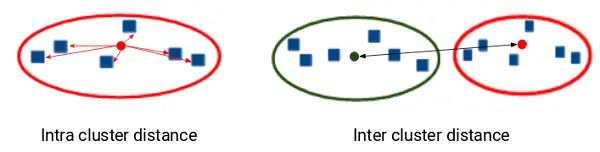

**Intra-cluster Distance**

* The average distance between the points within the same cluster.
* It tells us how far the points within a cluster are.

Normally,
* we use **Euclidean distance** as the distance metric, as long as most of the features are numeric
* otherwise, **Manhattan distance** in case most of the features are categorical.

**Inter-cluster Distance**

* The average distance between centroids in different clusters.
*  It measures how far apart the clusters are from each other.

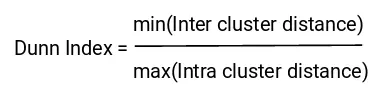

___
**Steps of K-means Algorithm:**
1. **Initialization:** Randomly initialize K centroids (either by selecting random data points or by some other method).
2. **Assignment Step:** Assign each data point to the nearest centroid. This is usually done by calculating the Euclidean distance between each point and each centroid.
3. **Update Step:** After assigning the points, recalculate the centroids of the K clusters by taking the mean of all points within each cluster.
4. **Repeat:** Repeat steps 2 and 3 until the centroids no longer change or a maximum number of iterations is reached.
5. **Final Result:** Once convergence is achieved, the algorithm outputs the final cluster centroids and the assignment of each data point to a cluster.
___

**How to Choose K?**

**Elbow Method**

The Elbow Method is a popular technique used to determine the optimal number of clusters (k) for KMeans clustering.

The idea is to compute the within-cluster sum of squares (WCSS, also known as inertia) for different values of k, and then look for an "elbow" point where the decrease in WCSS begins to slow down.

___

**Silhouette Score**

The silhouette score and plot are ***used to evaluate*** the quality of a clustering solution produced by the k-means algorithm.

The coefficient ranges from -1 to 1, where
* a value close to 1 indicates a well-clustered data point,
* a value close to 0 suggests overlapping clusters, and
* a value close to -1 indicates a misclassified data point.
___
**cohesion:** (how close a data point is to other points in its own cluster)

**separation:** (how far a data point is from points in other clusters)
___
**Calculating the Silhouette Coefficient:**

For each data point, calculate two values:

— Average distance to all other data points within the same cluster (cohesion).

— Average distance to all data points in the nearest neighboring cluster (separation).

**The Silhouette Coefficient: A Formula for Precision**
* silhouette coefficient = (separation — cohesion) / max(separation, cohesion)

# K-means Implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

class KMeans:
    def __init__(self, k=3, max_iter=200, tolerance=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.clusters = {}
        self.wcss = []
        self.sil_scores = []

    def _init_Centroids(self, X):
        # Initialize centroids randomly from the dataset
        random_idx = np.random.choice(X.shape[0], self.k, replace=False)
        return X[random_idx]

    def _init_Clusters(self):
        return { idx: {'centroid': self.centroids[idx], 'points': []} for idx in range(self.k)}

    def EuclideanDistance(self,p1,p2):
        return np.sqrt(np.sum((p1-p2)**2))

    def _assign_Clusters(self):
        for idx in range(self.k):
            self.clusters[idx]['points'] = []

        for idx, point in enumerate(self.X):
            distances = [self.EuclideanDistance(point, centroid) for centroid in self.centroids]
            min_centroid_idx = np.argmin(distances)
            self.clusters[min_centroid_idx]['points'].append(point)

    def _update_Clusters(self):
        for idx in range(self.k):
            if(self.clusters[idx]['points']):
                self.clusters[idx]['centroid'] = np.mean(self.clusters[idx]['points'], axis=0)

    def _plot_data(self):
        plt.scatter(self.X[:,0], self.X[:,1])
        centroids_array = np.array([self.clusters[idx]['centroid'] for idx in range(self.k)])
        plt.scatter(centroids_array[:, 0], centroids_array[:, 1], c='red')
        plt.show()

    def _test_tolerance(self):
        # Check if centroids have moved less than the tolerance threshold
        max_shift = 0
        for idx in range(self.k):
            shift = self.EuclideanDistance(self.centroids[idx], self.clusters[idx]['centroid'])
            max_shift = max(max_shift, shift)

        if max_shift < self.tolerance:
            return True
        else:
            # Update centroids to the new centroids in clusters
            self.centroids = [self.clusters[idx]['centroid'] for idx in range(self.k)]
            return False

    def fit(self, X):
        self.X = X
        self.centroids = self._init_Centroids(X)
        self.clusters = self._init_Clusters()
        for i in range(self.max_iter):
            self._assign_Clusters()
            self._update_Clusters()
            if(self._test_tolerance()):
                print(f'k-means: {self.k}, Converged after {i} iterations.')
                # print(self.clusters)
                break

    def predict(self, X):
        # Assign each point to the nearest centroid
        labels = []
        for point in X:
            distances = [self.EuclideanDistance(point, centroid) for centroid in self.centroids]
            min_centroid_idx = np.argmin(distances)
            labels.append(min_centroid_idx)
        return np.array(labels)


    def silhouette_score(self):
        # Create a list of all points and their assigned cluster labels
        labels = []
        points = []
        for idx in range(self.k):
            cluster_points = np.array(self.clusters[idx]['points'])
            points.extend(cluster_points)
            labels.extend([idx] * len(cluster_points))

        points = np.array(points)
        labels = np.array(labels)

        # Calculate the silhouette score using sklearn
        return silhouette_score(points, labels)

    def _compute_WCSS(self):
        # Compute the Within-Cluster Sum of Squares (WCSS)
        wcss = 0
        for idx in range(self.k):
            cluster_points = np.array(self.clusters[idx]['points'])
            if len(cluster_points) > 0:  # Only compute WCSS for non-empty clusters
                centroid = self.clusters[idx]['centroid']
                wcss += np.sum((cluster_points - centroid) ** 2)
        return wcss

    def evaluate_K(self, X, max_k=10):
        for k in range(1, max_k + 1):
            self.k = k
            self.centroids = self._init_Centroids(X)
            self.clusters = self._init_Clusters()
            self.fit(X)  # Fit the model to X
            if(k > 1): self.sil_scores.append(kmeans.silhouette_score())
            self.wcss.append(self._compute_WCSS())  # Calculate WCSS for this k

k-means: 3, Converged after 1 iterations.
{0: {'centroid': array([9.        , 3.33333333]), 'points': [array([8, 3]), array([9, 2]), array([10,  5])]}, 1: {'centroid': array([7., 9.]), 'points': [array([ 6, 10]), array([7, 8]), array([8, 9])]}, 2: {'centroid': array([3., 5.]), 'points': [array([2, 5]), array([3, 4]), array([4, 6])]}}


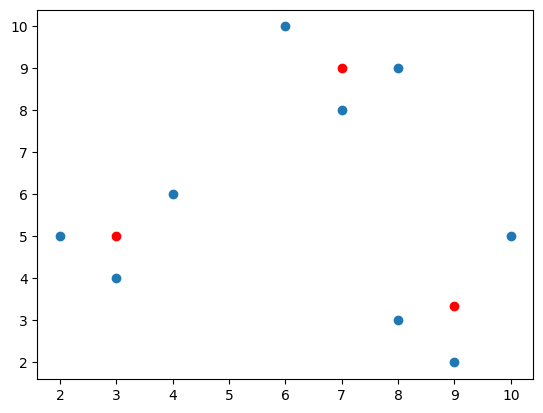

Predicted cluster labels: [2 1 0]


In [ ]:
X = np.array([
    [2, 5], [3, 4], [4, 6],  # Cluster 1
    [6, 10], [7, 8], [8, 9],   # Cluster 2
    [8, 3], [9, 2], [10, 5]  # Cluster 3
])

# Step 3: Apply KMeans clustering
kmeans = KMeans(k=3, max_iter=10)
labels = kmeans.fit(X)
print(kmeans.clusters)
kmeans._plot_data()


pred_data_points = np.array([
    [3, 5],   # A point close to Cluster 1
    [7, 8],   # A point close to Cluster 2
    [8, 4],   # A point close to Cluster 3
])

# Using the trained model to predict the clusters
predictions = kmeans.predict(pred_data_points)

# Print the predicted cluster labels for the new data points
print("Predicted cluster labels:", predictions)

k-means: 1, Converged after 1 iterations.
k-means: 2, Converged after 1 iterations.
k-means: 3, Converged after 1 iterations.
k-means: 4, Converged after 2 iterations.
k-means: 5, Converged after 1 iterations.
k-means: 6, Converged after 1 iterations.
k-means: 7, Converged after 1 iterations.
k-means: 8, Converged after 1 iterations.


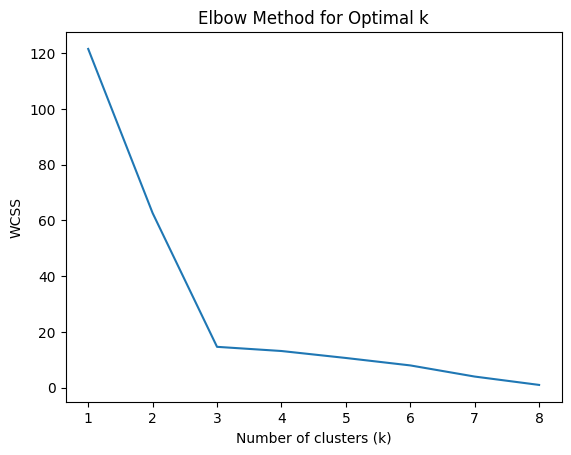

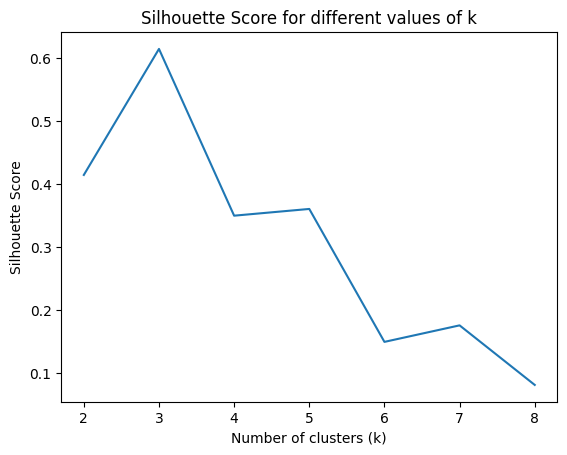

In [ ]:
kmeans.evaluate_K(X, max_k=8)
wcss = kmeans.wcss
sil_scores = kmeans.sil_scores

# Plot the WCSS vs. number of clusters
plt.plot(range(1, 9), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Plot Silhouette Score for different values of k
plt.plot(range(2, 9), sil_scores)
plt.title('Silhouette Score for different values of k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Example data points
X = np.array([
    [2, 5], [3, 4], [4, 6],  # Cluster 1
    [6, 10], [7, 8], [8, 9],   # Cluster 2
    [8, 3], [9, 2], [10, 5]  # Cluster 3
])
# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

# Get cluster centers and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print("Cluster centers:", centroids)
print("Labels:", labels)


Cluster centers: [[7.         9.        ]
 [9.         3.33333333]
 [3.         5.        ]]
Labels: [2 2 2 0 0 0 1 1 1]


#50 interview questions on K-means clustering for machine learning engineers

## Basic Concepts

1. What is K-means clustering?

K-means is an unsupervised machine learning algorithm used to partition data into K clusters, where each data point belongs to the cluster whose centroid (mean) is closest.
___
2. What is the role of the parameter K in K-means clustering?

K is the number of clusters the algorithm will partition the data into. It is a user-defined parameter, and the algorithm minimizes the sum of squared distances from each point to its assigned cluster's centroid.
___
3. Explain the basic working of the K-means algorithm.

K-means works by initializing K centroids, assigning each data point to the nearest centroid, updating centroids by calculating the mean of assigned points, and repeating the process until convergence.
___
4. How do you initialize the centroids in K-means?

Centroids can be initialized randomly from the dataset, or using K-means++ which selects centroids that are far apart to reduce the chances of poor initialization.
___
5. How do you choose the optimal number of clusters (K) in K-means?

You can use methods like the Elbow method, where you plot the cost (inertia) for different values of K and look for an "elbow" where the cost reduction slows down. The Silhouette score is another method.
___
6. What distance metric does K-means use?

K-means typically uses Euclidean distance to calculate the distance between a point and a centroid.
___
7. What are the main steps involved in the K-means algorithm?

The main steps are:
* Initialize centroids.
* Assign points to the nearest centroid.
* Update centroids by averaging the points in each cluster.
* Repeat until centroids do not change.
___
8. What is the importance of the centroids in K-means clustering?

Centroids represent the "center" of a cluster and are used to assign data points to clusters. The algorithm aims to minimize the sum of squared distances between points and their respective centroids.
___
9. What are the assumptions made by K-means?

K-means assumes that clusters are spherical, equally sized, and have similar densities. It also assumes that Euclidean distance is an appropriate metric.
___
10. Can K-means work for categorical data? Why or why not?

K-means is not suitable for categorical data because the algorithm relies on Euclidean distance, which is not defined for categorical values. K-modes or K-prototype algorithms can be used instead.
___
11. What does the term "convergence" mean in the context of K-means?

Convergence occurs when the centroids no longer change significantly between iterations, meaning the algorithm has found a stable solution.
___
12. What is the objective function in K-means?

The objective function is to minimize the sum of squared distances from each point to its assigned centroid. This is called the within-cluster sum of squares (WCSS).
___
13. What happens if we use a value of K that is too high or too low?

If K is too low, it may result in underfitting, grouping distinct clusters together. If K is too high, it may result in overfitting, where the clusters are too fine and do not generalize well.
___
14. Can K-means clustering be applied to datasets with non-spherical clusters?

No, K-means performs poorly on non-spherical clusters as it assumes that clusters are convex and equally sized.
___
15. What are the possible issues with the K-means algorithm?

Issues include poor initialization of centroids, sensitivity to outliers, choosing the wrong value for K, and performance degradation for non-spherical clusters.
___
16. What is the effect of random initialization of centroids in K-means?

Random initialization can lead to poor clustering results if the centroids are initialized in a way that causes them to be too close to each other, leading to convergence in suboptimal solutions.
___
17. What are some methods to address the problem of poor initialization in K-means?

The K-means++ initialization method improves centroid selection, reducing the chances of poor clustering and improving convergence speed.

___
18. How does the K-means algorithm handle overlapping clusters?
K-means struggles with overlapping clusters because it assigns data points to a single cluster based on proximity to the centroid, ignoring potential overlaps
___

## Practical/Technical Questions

19. How would you implement K-means clustering from scratch?

I would implement K-means by initializing centroids, assigning points to the nearest centroid, recalculating centroids, and repeating until convergence.
___
20. How do you calculate the distance between a point and a centroid in K-means?

The distance is typically calculated using Euclidean distance.
___
21. How does K-means handle large datasets?

K-means can struggle with large datasets due to high computational complexity. Using techniques like Mini-batch K-means can help by processing small random subsets of the data at each iteration.
___
22. How do you deal with outliers when performing K-means clustering?

K-means is sensitive to outliers. To deal with this, you can use Robust K-means or K-medoids, which are less sensitive to outliers.
___
23. How would you optimize K-means to handle high-dimensional data?

You can use dimensionality reduction techniques like PCA (Principal Component Analysis) before applying K-means to reduce the number of dimensions and make the algorithm more efficient.
___
24. What is the role of the max_iter parameter in K-means?

max_iter controls the maximum number of iterations the algorithm will run. If the algorithm reaches this limit before convergence, it will stop.
___
25. Can K-means be used for dimensionality reduction?

K-means is not directly used for dimensionality reduction, but it can help with feature selection by identifying clusters of similar features, which can then be used for feature extraction.
___
26. What is the difference between K-means and K-means++ initialization?

K-means++ chooses initial centroids that are more spread out to improve convergence, while the standard K-means picks centroids randomly, which can lead to poor results.
___
27. How do you determine the number of clusters (K) in an unsupervised learning scenario?

Methods like the Elbow method, Silhouette score, or Gap statistic can be used to determine the optimal K by evaluating the clustering quality for different values of K.
___
28. What is the elbow method and how does it help in selecting the optimal K?

The elbow method involves plotting the cost (inertia) vs. the number of clusters and selecting K where the cost reduction starts to level off (forming an "elbow").
___
29. What is the silhouette score? How is it used to evaluate K-means clustering?

The silhouette score measures how similar a point is to its own cluster compared to other clusters. A high silhouette score indicates well-defined clusters.
___
30. What are the challenges faced when clustering data with K-means in the presence of noise?

K-means is sensitive to noise as it assigns outliers to the nearest centroid, which can distort the cluster centroids. Using robust methods like K-medoids can help mitigate this.
___
31. If two clusters in K-means have the same centroid, how does K-means handle them?

This situation is rare. However, K-means would likely split the points between the two centroids during the assignment step, and the centroids may be updated accordingly.
___
32. How do you visualize clusters obtained from K-means in 2D and 3D?

In 2D, you can plot the data points with different colors for each cluster. In 3D, you can use a 3D scatter plot. Techniques like PCA can also reduce dimensions for visualization.
___
33. Can K-means clustering be used for anomaly detection? If yes, how?

Yes, K-means can be used for anomaly detection by calculating the distance of a point from its assigned centroid. Points that are far from their centroids may be considered anomalies.
___
34. In what scenarios would you choose K-means over other clustering algorithms (e.g., DBSCAN, Agglomerative)?

K-means is best for well-separated spherical clusters with similar densities. It is efficient for large datasets but may struggle with complex shapes or noise.
___

## Advanced Topics

35. Explain the K-means algorithm’s convergence proof.

K-means converges because it minimizes an objective function, which is the sum of squared Euclidean distances between points and their centroids. In each iteration:
* During the assignment step, the algorithm assigns each point to the nearest centroid, reducing the total distance to the centroids.
* During the update step, the centroids are recomputed as the mean of the points assigned to them, which further minimizes the objective function.

Since each iteration results in a decrease (or at least no increase) in the objective function, the algorithm will eventually converge to a local minimum.
___
36. How do you handle categorical features in K-means clustering?

K-means is not suitable for categorical data directly, as it relies on Euclidean distance, which doesn't make sense for categorical variables.
* K-modes clustering is specifically designed for categorical data and uses the mode (most frequent value) instead of the mean to compute centroids.
* K-prototype clustering combines K-means and K-modes by handling both numerical and categorical features.
___
37. Can K-means be used for semi-supervised learning?

K-means is typically an unsupervised learning algorithm. However, semi-supervised learning can be incorporated by:
* Constrained K-means, where some points are labeled (must-link or cannot-link constraints).
* Using partially labeled datasets to guide the centroid initialization or the assignment of points.
___
38. What are some limitations of K-means when working with sparse datasets?

K-means can struggle with sparse datasets because:
The Euclidean distance can be misleading in high-dimensional, sparse data (many zeros).
* Centroids may be computed in a way that does not reflect the true structure of the data.
* Distance-based algorithms like K-means perform poorly when the data is high-dimensional and sparse due to the "curse of dimensionality."
___
39. How would you modify K-means to deal with non-Euclidean distance metrics?

K-means can be modified to use non-Euclidean distance metrics (e.g., Manhattan distance, Cosine similarity, etc.) by:
* Replacing the Euclidean distance function with the desired distance metric in the assignment step.
* Alternatively, using kernel methods to map data into higher-dimensional spaces where Euclidean distance may become more meaningful.
___
40. What would you do if the K-means algorithm is not converging?

If K-means is not converging:
* Check for poor initialization: Use K-means++ to initialize centroids more effectively.
* Check for outliers: Outliers can prevent convergence by pulling centroids away from the main cluster.
* Increase the maximum number of iterations: Sometimes, K-means may take more iterations to converge, especially for large datasets.
* Choose a better K value: If the number of clusters is poorly chosen, it may prevent convergence.
___
41. What are alternative clustering algorithms to K-means, and when would you use them instead?
* DBSCAN (Density-Based Spatial Clustering of Applications with Noise): Suitable for clusters with varying shapes and densities, and it handles noise (outliers) well.
* Agglomerative Hierarchical Clustering: Works well when the number of clusters is not known in advance and is better for hierarchical structures.
* Gaussian Mixture Models (GMM): Suitable for data that assumes Gaussian distributions, handling clusters with ellipsoidal shapes and different densities.
___
42. What is a common approach to handling the problem of empty clusters in K-means?

If a cluster becomes empty, K-means can reinitialize that centroid randomly or by selecting the farthest point from the current centroids to maintain diversity among clusters.
___
43. Can you explain how the K-means algorithm behaves when clusters are of different densities?

K-means assumes clusters are of similar sizes and densities. When clusters have different densities:
* K-means may fail to correctly identify them.
* The algorithm may over-merge denser clusters or under-merge sparser clusters.
* DBSCAN or Gaussian Mixture Models are better suited for handling clusters of different densities.
___
44. How does K-means handle categorical data with more than two possible values for each feature?

K-means does not directly handle categorical features with more than two possible values. To use K-means, categorical data must be transformed into numerical representations (e.g., One-Hot Encoding) before applying K-means. Alternatively, K-modes can be used for clustering categorical data.
___
45. What is the impact of using different initialization techniques for K-means clustering (random, K-means++, etc.)?
* Random initialization can lead to suboptimal clustering because centroids may start close to each other.
* K-means++ helps by selecting centroids that are more spread out, improving convergence speed and reducing the chance of getting stuck in local minima.
* Random can result in slow convergence, while K-means++ often yields better and faster convergence to a global minimum.
___
46. How do you scale or normalize data before applying K-means clustering?

Scaling or normalizing the data ensures that features with larger ranges don’t dominate the distance computation:
* Use Standardization (subtract the mean and divide by the standard deviation) to scale data to have a mean of 0 and a standard deviation of 1.
* Min-Max Scaling scales features to a specific range (usually 0 to 1).
* Normalization adjusts the data to a unit norm (length 1) in vector space.
___
47. Explain the difference between batch K-means and online K-means algorithms.

* Batch K-means processes all data points at once in each iteration, which may be computationally expensive for large datasets.
* Online K-means (Mini-batch K-means) processes small random subsets of the data (mini-batches) at each iteration, making it faster for large datasets.
___
48. What are the major differences between K-means clustering and K-medoids clustering?

* K-means uses the mean of data points as the centroid, making it sensitive to outliers.
* K-medoids uses actual data points as cluster representatives (medoids), which makes it more robust to outliers.
* K-medoids is computationally more expensive than K-means but is more suitable for data with outliers.
___
49. How would you handle a scenario where the number of clusters (K) is not known beforehand?

* Use techniques like the Elbow method, Silhouette score, or Gap statistic to determine the optimal K.
* Alternatively, methods like DBSCAN or Gaussian Mixture Models can automatically detect the number of clusters based on data characteristics.
___
50.How does K-means behave when there is a large number of outliers in the dataset?

K-means is sensitive to outliers, as they can pull centroids away from the main cluster. To mitigate this, consider using Robust K-means, K-medoids, or DBSCAN, which are less affected by outliers.
___

## Practical Use Cases

1. What would be the result if you choose K=1 in K-means clustering?

If K=1, the algorithm will assign all points to a single cluster, and the centroid will be the mean of all the data points. It will not capture any meaningful structure in the data.
___
2. How would you use K-means to cluster images?

Treat each image as a vector by flattening it into a 1D array, and apply K-means clustering to group similar images. This works well for images that have similar features. For better results, feature extraction techniques like PCA or CNNs can be used before applying K-means.
___
3. Explain a scenario where K-means clustering would fail.

K-means would fail in scenarios where clusters have different shapes, densities, or are overlapping (e.g., crescent-shaped clusters). In such cases, algorithms like DBSCAN or Agglomerative Hierarchical Clustering are more appropriate.
___
4. How would you apply K-means clustering to customer segmentation in a business context?

K-means can be used to segment customers based on features like purchasing behavior, demographics, and preferences. By clustering customers into groups, businesses can target marketing efforts, personalize recommendations, or optimize customer service for each segment.
___
5. Can K-means clustering be applied to time series data? Explain how.

K-means can be applied to time series data by transforming the time series into feature vectors (e.g., using Fourier transforms or window-based techniques). K-means can then group similar time series based on their patterns, trends, or other characteristics. However, K-means may not capture temporal dependencies as well as specialized time-series clustering methods like Dynamic Time Warping (DTW).
___

## Important info

* K-Means Clustering is renowned for both its simplicity and effectiveness. However, it is classified as a **greedy algorithm**, featuring straightforward steps with local and current decision-making criteria.

# Image Segmentation using K Means Clustering

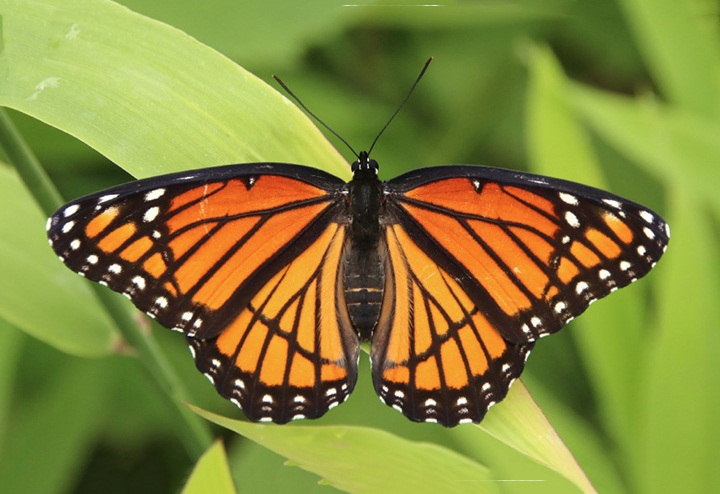

In [ ]:
import numpy as np
import cv2
import requests
from io import BytesIO
from google.colab.patches import cv2_imshow
from PIL import Image

# Image URL
url = 'https://www.butterflyidentification.com/wp-content/uploads/2020/02/Butterfly-Facts.jpg'

# Get image content from URL
response = requests.get(url)
image_bytes = BytesIO(response.content)

# Open image with PIL
pil_image = Image.open(image_bytes)

# Convert image to numpy array
image = np.array(pil_image)

# Change color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Display the image
cv2_imshow(image)


In [ ]:
# Reshaping the image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = image.reshape((-1,3))

# Convert to float type
pixel_vals = np.float32(pixel_vals)


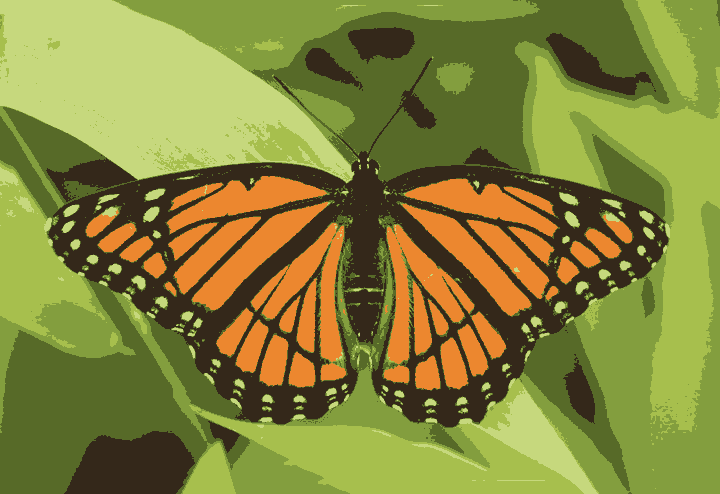

In [ ]:
# Step 3: Set criteria and apply kmeans
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 6  # Number of clusters (segments)
_, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Step 4: Convert centers to 8 bit values
centers = np.uint8(centers)

# Step 5: Map the labels to center values to form the segmented image
segmented_image = centers[labels.flatten()]

# Step 6: Reshape back to the original image shape
segmented_image = segmented_image.reshape(image.shape)

# Step 7: Display the segmented image
cv2_imshow(segmented_image)

Converged after 46 iterations.


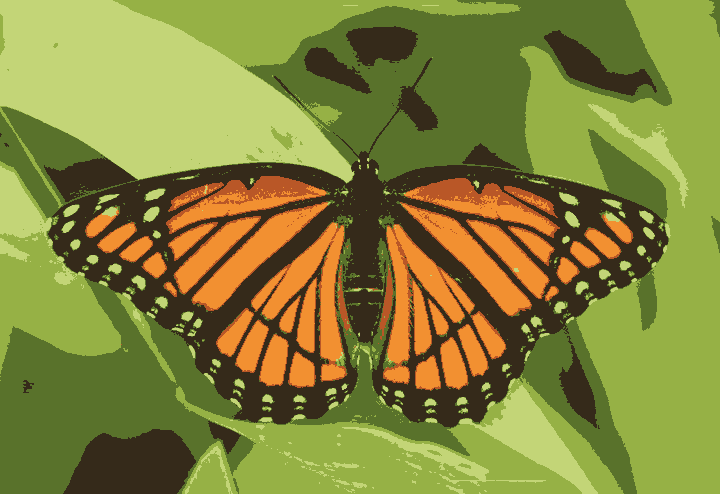

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import requests
from io import BytesIO
from PIL import Image

# Download image from URL
url = 'https://www.butterflyidentification.com/wp-content/uploads/2020/02/Butterfly-Facts.jpg'
response = requests.get(url)
image_bytes = BytesIO(response.content)

# Open image with PIL
pil_image = Image.open(image_bytes)

# Convert image to numpy array
image = np.array(pil_image)

# Convert to RGB if necessary
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Step 1: Reshape the image to a 2D array (height*width, 3) for pixel clustering
pixels = image.reshape((-1, 3))  # Flatten the image to a 2D array (height*width, 3)

# Step 2: Normalize pixel values (optional but helps for stability)
pixels = pixels / 255.0

# Step 3: Initialize random centroids
k = 6  # Number of clusters (segments)
np.random.seed(42)  # For reproducibility
centroids = pixels[np.random.choice(pixels.shape[0], k, replace=False)]

# Step 4: K-means clustering loop
max_iters = 100
prev_centroids = centroids.copy()
labels = np.zeros(pixels.shape[0])

for i in range(max_iters):
    # Step 4a: Assign pixels to nearest centroid
    distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    # Step 4b: Update centroids (mean of the assigned pixels)
    for j in range(k):
        centroids[j] = np.mean(pixels[labels == j], axis=0)

    # Step 4c: Check for convergence (if centroids don't change)
    if np.all(np.abs(centroids - prev_centroids) < 1e-4):
        print(f"Converged after {i+1} iterations.")
        break

    prev_centroids = centroids.copy()

# Step 5: Reconstruct the segmented image
segmented_pixels = centroids[labels]
segmented_image = segmented_pixels.reshape(image.shape)

# Step 6: Convert back to 8-bit image (for display)
segmented_image = (segmented_image * 255).astype(np.uint8)

# Step 7: Display the segmented image
cv2_imshow(segmented_image)


# Movie Recommendation System Using K-Means Clustering

#K-means++

**How K-means++ Works:**

Instead of randomly selecting the initial centroids, K-means++ selects them more intelligently. The idea is to spread out the initial centroids to increase the chances of finding a better solution.
* Step 1: Select the first centroid randomly from the data points.

* Step 2: For each remaining data point, compute its distance from the nearest centroid already selected (using squared Euclidean distance).

* Step 3: Choose the next centroid from the remaining points, with a probability proportional to the squared distance from the nearest centroid. This means that points farther from the already chosen centroids are more likely to be selected.

* Step 4: Repeat steps 2-3 until all centroids have been selected.

In [ ]:
import numpy as np

def kmeans_pp_init(X, k):
    """
    K-means++ initialization to choose k centroids
    X: Input data (numpy array)
    k: Number of clusters
    """
    # Number of data points
    n = X.shape[0]

    # Randomly select the first centroid
    centroids = [X[np.random.choice(n)]]

    # Select the remaining centroids using K-means++ logic
    for _ in range(1, k):
        # Calculate the distance of all points from the nearest centroid
        dist_sq = np.min(np.sum((X - centroids[0])**2, axis=1))
        for i in range(1, len(centroids)):
            dist_sq = np.minimum(dist_sq, np.sum((X - centroids[i])**2, axis=1))

        # Choose the next centroid with probability proportional to the squared distance
        prob = dist_sq / dist_sq.sum()
        next_centroid = X[np.random.choice(n, p=prob)]
        centroids.append(next_centroid)

    return np.array(centroids)

def kmeans(X, k, max_iters=100):
    """
    K-means++ clustering algorithm
    X: Input data (numpy array)
    k: Number of clusters
    max_iters: Maximum number of iterations
    """
    # Step 1: Initialize centroids using K-means++
    centroids = kmeans_pp_init(X, k)

    for _ in range(max_iters):
        # Step 2: Assign each data point to the nearest centroid
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        labels = np.argmin(distances, axis=0)

        # Step 3: Recalculate centroids (mean of points in each cluster)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Step 4: Check for convergence (centroids have not changed)
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels

# Example usage:
# Let's say X is our dataset with shape (n_samples, n_features)
# X = np.random.rand(100, 2)  # Example data: 100 points, 2 features
# k = 3  # Number of clusters
# centroids, labels = kmeans(X, k)
